<a href="https://colab.research.google.com/github/ogunjosam/osogbo_purpleair_chaos/blob/main/osogbo_purpleair_chaos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chaotic and multifractal analysis of atmospheric variables at different temporal resolution in a tropical location

In this study, we will look at atmospheric variable (temperature, pressure, relative humidity) and pollutants (PM1, PM2.5, PM10) at different temporal resolution (2, 4, 6, 8, 10 minutes).  The analysis will be carried out on a monthly basis to see the seasonal variations while bypassing the data length restrictions. 

Tentatively, the following analysis will be carried out

1. Lyapunov exponent
2. Correlation dimension
3. Sample entropy
4. Multifractal analysis

Install and import packages here

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Plot the time series for the variables

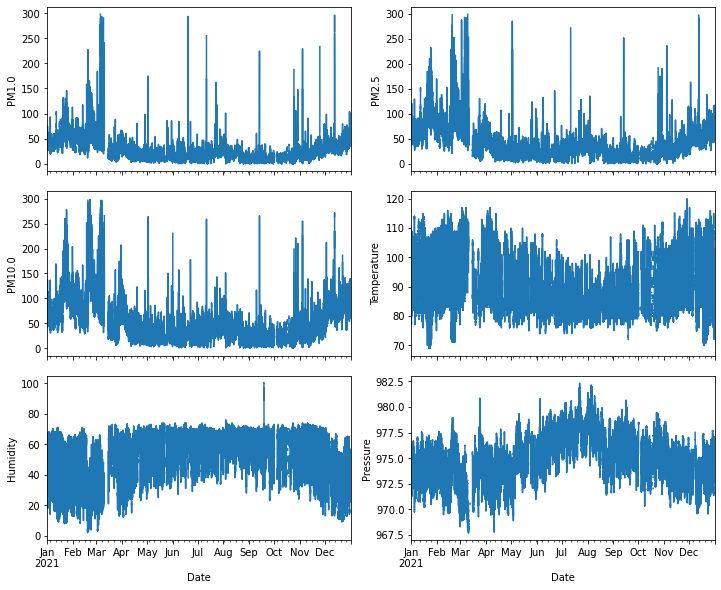

In [9]:
fig,ax = plt.subplots(3,2,figsize=(10,8),sharex=True,sharey=False)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
plt.tight_layout(h_pad=1,w_pad=3)
axf = ax.flatten()

url = 'https://github.com/ogunjosam/osogbo_purpleair_chaos/raw/main/osogbo_chaos_final.xlsx'
xx = pd.read_excel(url,index_col='Date')

for i,ii in enumerate(list(xx)):
  if ii.startswith('PM'):
    xx[xx[ii]>300] = np.nan
  xx[ii].plot(ax=axf[i])
  axf[i].set_ylabel(ii)